In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
from statsmodels.formula.api import ols
from scipy import stats
import statsmodels.formula.api as smf

In [3]:
def filter_variables(df, dict_variables) :
    inicial = True
    for key in dict_variables.keys() :
        if type(dict_variables[key]) == str:
            if inicial :
                filtro = f"({key}\'{dict_variables[key]}\')"
                inicial = False
            else:
                filtro = filtro + f" and ({key}\'{dict_variables[key]}\')"
        else:
            if inicial :
                filtro = f"({key}{dict_variables[key]})"
                inicial = False
            else:
                filtro = filtro + f" and ({key}{dict_variables[key]})"

    return pd.DataFrame(df.query(filtro))

In [4]:
data = pd.read_csv('performances.csv')
data.shape

(20735, 14)

In [5]:
data.head()

,treatment,dyad,player,expert_in,novice_in,stage,round,kind,expert_dog,classif,accuracy,queried,answered,answer_correct
0,single,32519-32519,325192931513079,terrier,hound,Training rounds,1,C,NaN,C,1,NaN,NaN,NaN
1,single,32519-32519,325192931513079,terrier,hound,Training rounds,1,A,NaN,C,0,NaN,NaN,NaN
2,single,32519-32519,325192931513079,terrier,hound,Training rounds,1,A,NaN,A,1,NaN,NaN,NaN
3,single,32519-32519,325192931513079,terrier,hound,Training rounds,1,A,NaN,A,1,NaN,NaN,NaN
4,single,32519-32519,325192931513079,terrier,hound,Training rounds,1,A,NaN,A,1,NaN,NaN,NaN


In [6]:
game_dyads = filter_variables(data, {
    'treatment==':'dyad', 
    'stage==':'Game rounds',
    'expert_dog==':False,
    'round<':60
})
game_dyads['queried'] = game_dyads['queried'].apply(lambda x: 1 if x>0 else 0)
game_dyads.head()

,treatment,dyad,player,expert_in,novice_in,stage,round,kind,expert_dog,classif,accuracy,queried,answered,answer_correct
11206,dyad,45981-38174,459819203408978,hound,terrier,Game rounds,1,C,False,A,0,0,NaN,NaN
11209,dyad,45981-38174,459819203408978,hound,terrier,Game rounds,1,A,False,C,0,0,NaN,NaN
11210,dyad,45981-38174,38174543864515,terrier,hound,Game rounds,1,B,False,B,1,0,NaN,NaN
11212,dyad,45981-38174,38174543864515,terrier,hound,Game rounds,1,B,False,D,0,0,NaN,NaN
11213,dyad,45981-38174,38174543864515,terrier,hound,Game rounds,1,B,False,D,0,0,NaN,NaN


In [7]:
df_use = game_dyads.groupby(['player', 'round']).agg({'queried':['sum', 'count'], 'accuracy':'mean'}).reset_index()
df_use.columns = df_use.columns.get_level_values(0)
df_use.columns = ['player', 'round', 'sum', 'count', 'accuracy']
df_use['use'] = df_use['sum'] / df_use['count']
df_use = df_use[['player', 'round', 'use', 'accuracy']]
df_use['new_use'] = df_use.groupby('player')['use'].transform('shift',-1)
df_use = df_use.dropna()
df_use.head(30)

,player,round,use,accuracy,new_use
0,21409433577947,3,0.333333,0.000000,0.333333
1,21409433577947,4,0.333333,0.333333,0.333333
2,21409433577947,5,0.333333,0.333333,0.500000
3,21409433577947,6,0.500000,1.000000,1.000000
4,21409433577947,7,1.000000,1.000000,0.666667
5,21409433577947,8,0.666667,0.666667,0.500000
6,21409433577947,9,0.500000,0.500000,1.000000
7,21409433577947,10,1.000000,1.000000,1.000000
8,21409433577947,11,1.000000,1.000000,1.000000
9,21409433577947,12,1.000000,1.000000,0.666667


<AxesSubplot:xlabel='accuracy', ylabel='new_use'>

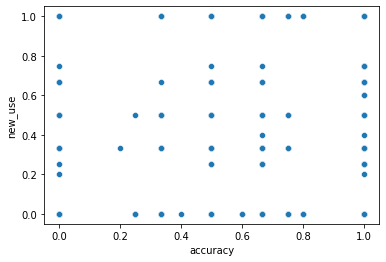

In [8]:
sns.scatterplot(data=df_use, x='accuracy', y='new_use')

In [9]:
mod = smf.ols(formula='new_use ~  accuracy', data=df_use)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                new_use   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     8.495
Date:                Wed, 13 Oct 2021   Prob (F-statistic):            0.00365
Time:                        20:54:33   Log-Likelihood:                -523.95
No. Observations:                 912   AIC:                             1052.
Df Residuals:                     910   BIC:                             1062.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2918      0.042      6.924      0.0

In [10]:
mod = smf.ols(formula='new_use ~  accuracy * use', data=df_use)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                new_use   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     281.5
Date:                Wed, 13 Oct 2021   Prob (F-statistic):          3.61e-129
Time:                        20:54:33   Log-Likelihood:                -228.31
No. Observations:                 912   AIC:                             464.6
Df Residuals:                     908   BIC:                             483.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1860      0.038      4.869   

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
md = smf.mixedlm("new_use ~ accuracy + round", df_use, groups=df_use["player"])
mdf = md.fit()
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: new_use  
No. Observations: 912     Method:             REML     
No. Groups:       40      Scale:              0.0690   
Min. group size:  20      Log-Likelihood:     -157.3635
Max. group size:  24      Converged:          Yes      
Mean group size:  22.8                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.540    0.062  8.732 0.000  0.419  0.662
accuracy     -0.026    0.034 -0.771 0.441 -0.092  0.040
round        -0.009    0.001 -6.577 0.000 -0.011 -0.006
Group Var     0.118    0.107                           



In [12]:
df_use.groupby('player')['use'].mean().describe()

count    40.000000
mean      0.410459
std       0.338793
min       0.000000
25%       0.093379
50%       0.316365
75%       0.719697
max       0.984848
Name: use, dtype: float64

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='use', ylabel='Density'>

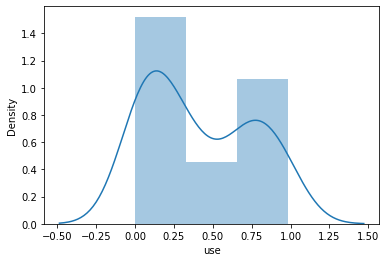

In [13]:
sns.distplot(df_use.groupby('player')['use'].mean())

Aprendizaje que muestra que la recompensa obtenida por el uso del lenguaje incita a mayor uso.

